# Survival Analysis

## 1. Import Libraries

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
%matplotlib inline
import lifelines
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
pd.options.mode.chained_assignment = None

## 2. Data Prepocessing

In [3]:
# load data
covid = pd.read_csv('covid19_data_22022021.csv',
                     dtype=dict(sex='category',
                                age='string',
                                city='category',
                                province='category',
                                country='category',
                                geo_resolution='category',
                                date_onset_symptoms='category',
                                date_admission_hospital='category',
                                symptoms='string',
                                additional_information='string',
                                date_death_or_discharge='category',
                                travel_history_dates='string',
                                notes_for_discussion='string',
                                latitude=float,
                                longitude=float,
                                lives_in_Wuhan='category',
                                travel_history_location='category',
                                reported_market_exposure='category',
                                chronic_disease_binary='category',
                                chronic_disease='category',
                                source='category',
                                sequence_available='category',
                                outcome='category',
                                #sequence_available=bool,
                                location='category',
                                admin3='category',
                                admin2='category',
                                admin1='category',
                                country_new='category',
                                travel_history_binary='category',
                                data_moderator_initials='category'
                                ),)

In [4]:
# display 5 data records
covid.head(2).style

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,nan,nan,21.02.2020,,nan,,nan,nan,Hospitalized on 12.02.2020 for other reasons,False,nan,https://www.corriere.it/cronache/20_febbraio_21/coronavirus-italia-cosa-sappiamo-casi-codogno-lombardia-27fa736c-548b-11ea-9196-da7d305401b7.shtml,nan,death,22.02.2020,,Vo' Euganeo,nan,nan,Veneto,Italy,8954.000000,nan,nan
1,000-1-100,61,female,nan,nan,Singapore,1.353460,103.815100,admin0,nan,nan,14.02.2020,,nan,,nan,nan,"Case 65; family member of Case 50, a DBS employee, as is Case 55",False,nan,https://www.channelnewsasia.com/news/singapore/coronavirus-covid-19-singapore-cases-grace-assembly-of-god--12434646 https://bnonews.com/wp-content/uploads/2020/02/2172020Cases.pdf,nan,discharge,17.02.2020,,nan,nan,nan,nan,Singapore,200.000000,nan,nan


In [5]:
# check if there are duplicated observations
covid.duplicated().value_counts()

False    572679
dtype: int64

There are no duplicated records.

In [6]:
covid.shape

(572679, 33)

### (a) Features Selection

In [7]:
cols = ['age','sex','date_confirmation','chronic_disease_binary','date_death_or_discharge','outcome']
data = covid[cols]

# display data
data.head(2)

,age,sex,date_confirmation,chronic_disease_binary,date_death_or_discharge,outcome
0,78,male,21.02.2020,False,22.02.2020,death
1,61,female,14.02.2020,False,17.02.2020,discharge


In [8]:
dim = data.shape
print('Chosen data has {} observations and {} features'.format(dim[0], dim[1]))

Chosen data has 572679 observations and 6 features


In [9]:
# check if the columns are in their right data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572679 entries, 0 to 572678
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   age                      572679 non-null  string  
 1   sex                      572679 non-null  category
 2   date_confirmation        572410 non-null  object  
 3   chronic_disease_binary   572679 non-null  category
 4   date_death_or_discharge  3094 non-null    category
 5   outcome                  33601 non-null   category
dtypes: category(4), object(1), string(1)
memory usage: 11.5+ MB


In [10]:
data.isnull().sum()

age                             0
sex                             0
date_confirmation             269
chronic_disease_binary          0
date_death_or_discharge    569585
outcome                    539078
dtype: int64

There are high amount of truncated cases.

**Confirmation Date**

In [11]:
# date_confirmation is in the wrong format. There are also typos, the date is not a single date but a range
(data['date_confirmation'] == '25.02.2020 - 26.02.2020').value_counts()

False    572674
True          5
Name: date_confirmation, dtype: int64

In [12]:
# replace these with 25.02.2020
data.loc[(data['date_confirmation'] == '25.02.2020 - 26.02.2020'),'date_confirmation'] = '25.02.2020'

The right data type will be converted later when missing data is filled.

In [13]:
# verify the time data after changes
# set(data['date_confirmation'])

**Age**

In [14]:
# check unique values for each features
# pd.options.display.max_rows = 500 
pd.DataFrame(data['age'].value_counts())

,age
35-59,72589
15-34,44385
60-79,33026
80+,20172
80-89,11441
...,...
7 months,1
54.9,1
22-23,1
0.6,1


Age column has 349 unique values, ranging from months to years and year intervals. There are strings such as '+', '-', 'months'. They need removing. Only number should be kept.

**Age Groups**

In [15]:
# remove white space in age range
data['age'] = data['age'].str.replace(' ', '')

In [16]:
# clean the age column, include the higher bound
import re
upper_age = []
for i in data.index[:]: 
    if '-' in data.loc[i,'age']:
        x = (data.loc[i,'age'].split('-'))[-1]
        upper_age.append(x)
    elif (len(data.loc[i,'age']) > 6): 
        upper_age.append('2')
    else:
        upper_age.append(data.loc[i,'age'])

The upper bound of age ranges is used to categorize the age group. For example 35-59, 59 is used and it belongs to 'middle' group.

In [17]:
# verify if all age data is converted
len(upper_age) == data.shape[0]

True

In [18]:
upper_age = [re.sub('\D', '', i) for i in upper_age]
for i in upper_age:
    if i == '':
        upper_age[upper_age.index(i)] = '1'

In [19]:
# convert the age to float dtype
age = [round(float(i)) for i in upper_age]

In [20]:
age[:10]

[78, 61, 66, 27, 17, 51, 68, 26, 30, 53]

In [21]:
# category data into groups
age_cat = []
for i in age:
    if (i <= 40):
        age_cat.append('young')
    elif (i > 40) and (i <=65):
        age_cat.append('middle')
    elif (i > 65):
        age_cat.append('old')

In [22]:
# append the age group to dataset
data['age_cat'] = age_cat

In [23]:
data.shape

(572679, 7)

In [24]:
# verify the result
data.loc[:5, 'age_cat']

0       old
1    middle
2       old
3     young
4     young
5    middle
Name: age_cat, dtype: object

**Outcome**

In [25]:
pd.DataFrame(data['outcome'].value_counts())

,outcome
Hospitalized,27908
recovered,3656
died,912
Deceased,398
discharge,165
Recovered,139
stable condition,109
discharged,92
stable,66
death,41


There are typos in the categories such as:
- Hospitalized, Under treatment, treated in an intensive care unit(14.02.2020), Symptoms only improved with cough. Currently hospitalized for follow-up., Receiving Treatment
- recovered, Recovered
- discharge, discharged, released from quarantine, Discharged 
- stable condition, stable, Stable, recovering at home 03.03.2020	
- Alive
- severe, critical condition, severe illness, 
- not hospitalized
- **died, death, Dead, Died, Death, dead, Deceased --> died**

The observations needs re-categorizing to dead (1) and not dead (0) only. I will create a new column is_dead.

In [26]:
outcome = data['outcome'].str.lower()
outcome_cat = outcome.map({'dead':1,'died':1,'death':1,'deceased':1})
# missing values due to withdraw of study 
outcome_cat.fillna(0, inplace=True)

Create event column which indicate whether the customers died when their Covid-19 test result are positives

In [27]:
data['is_dead'] = outcome_cat

In [28]:
pd.DataFrame(data['is_dead'].value_counts())

,is_dead
0.0,571311
1.0,1368


The number of death is 1368.

**Missing Dates**

In [29]:
# statistics about confirmation date
data['date_confirmation'].describe(include='all', datetime_is_numeric=True)

count         572410
unique           152
top       09.04.2020
freq           12192
Name: date_confirmation, dtype: object

In [30]:
# statistics about dead or discharge date
data['date_death_or_discharge'].describe(include='all', datetime_is_numeric=True)

count           3094
unique           143
top       22.05.2020
freq              55
Name: date_death_or_discharge, dtype: object

569585 censoring cases (the event of interest has not occurred until the date on which we downloaded for the analysis) --> Fill these cases with 22.02.2021.

In [32]:
# fill censoring cases
data['date_death_or_discharge'] = data['date_death_or_discharge'].cat.add_categories('22.02.2021')
data['date_death_or_discharge'] = data['date_death_or_discharge'].fillna('22.02.2021')
data['date_confirmation'] = data['date_confirmation'].fillna('22.02.2021')

In [33]:
# change date_confirmation from object to datetime
data['date_confirmation'] = pd.to_datetime(data['date_confirmation'])
data['date_death_or_discharge'] = pd.to_datetime(data['date_death_or_discharge'])

In [34]:
# verify the data after cleaning
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572679 entries, 0 to 572678
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   age                      572679 non-null  string        
 1   sex                      572679 non-null  category      
 2   date_confirmation        572679 non-null  datetime64[ns]
 3   chronic_disease_binary   572679 non-null  category      
 4   date_death_or_discharge  572679 non-null  datetime64[ns]
 5   outcome                  33601 non-null   category      
 6   age_cat                  572679 non-null  object        
 7   is_dead                  572679 non-null  float64       
dtypes: category(3), datetime64[ns](2), float64(1), object(1), string(1)
memory usage: 23.5+ MB


**Survival Time**

In [35]:
# create survival_time column
survival_time = (data['date_death_or_discharge'] - data['date_confirmation']).abs()

# eliminate 'days' out of the survival_time
survival_days = survival_time.dt.days

In [36]:
# create new column on survival_duration
data['survival_duration'] = survival_days

In [37]:
data.describe()

,is_dead,survival_duration
count,572679.000000,572679.000000
mean,0.002389,281.961378
std,0.048817,73.611516
min,0.000000,0.000000
25%,0.000000,269.000000
50%,0.000000,293.000000
75%,0.000000,330.000000
max,1.000000,417.000000


The information for time-to-event


|  Information| Time-to-Event  |  
|:---|:---|
|  Event| Customer died |  
|  Time origin| Date Confirmation |  
|  Time scale|  Days |

## 3. Data Exploratory

In [38]:
viz = data[data['is_dead'] == 1].copy()

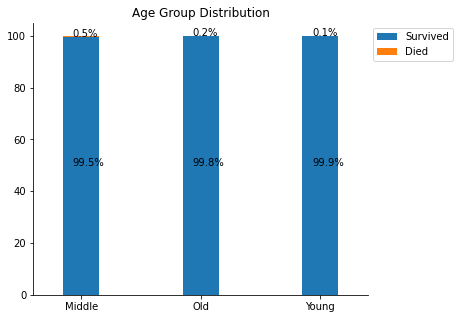

In [39]:
# visualize age groups 
ax = data.groupby(['age_cat','is_dead'])['is_dead'].count().groupby(level=0).apply(
                    lambda x: 100*x / x.sum()).unstack().plot.bar(stacked=True, ax=plt.gca(), width=0.3, figsize=(6,5))
plt.title('Age Group Distribution')
plt.legend(['Survived','Died'],bbox_to_anchor=(1,1))
ax.set_xticklabels(['Middle','Old','Young'],rotation=0)
plt.xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for p, q in zip(ax.patches[0:3], ax.patches[3:6]):
    ax.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.08, p.get_height()/2))
    ax.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.08, q.get_height()/2+p.get_height()))

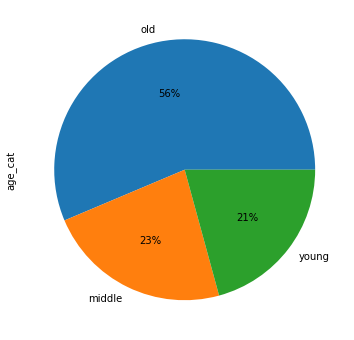

In [40]:
ax = data['age_cat'].value_counts().plot.pie(autopct='%1.0f%%',figsize = (10,6));

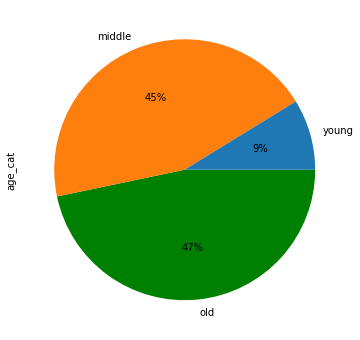

In [41]:
ax = viz['age_cat'].value_counts().plot.pie(autopct='%1.0f%%',figsize = (10,6),colors=['green','#ff7f0e','#1f77b4'],counterclock=False);

Elderly people are accounted only 21% of the dataset but 46% dead cases are in this age group. 

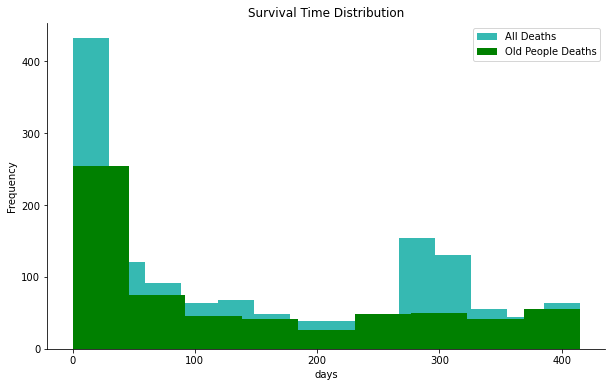

In [42]:
# old people and dead cases relation
ax = viz['survival_duration'].plot.hist(bins=14, alpha=0.9, label='All Deaths', figsize = (10,6), color='lightseagreen')
ax = viz['survival_duration'].loc[viz['age_cat'] =='old'].plot.hist(bins=9, label='Old People Deaths', figsize = (10,6), color='green')
ax.set_xlabel('days')
ax.set_title('Survival Time Distribution')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

 Most people died a month after received the positive test results. Very few cases lived more than 100 days.

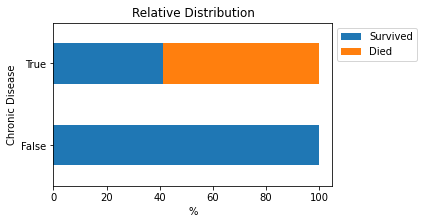

In [43]:
# visualize age groups 
ax = data.groupby(['chronic_disease_binary','is_dead'])['is_dead'].count().groupby(level=0).apply(
                    lambda x: 100*x / x.sum()).unstack().plot.barh(stacked=True, ax=plt.gca(), figsize=(5,3))
plt.title('Relative Distribution')
plt.legend(['Survived','Died'],bbox_to_anchor=(1,1))
plt.ylabel('Chronic Disease')
plt.xlabel('%');

## 4. Survival Analysis

### (f) Kaplan-Meier estimator

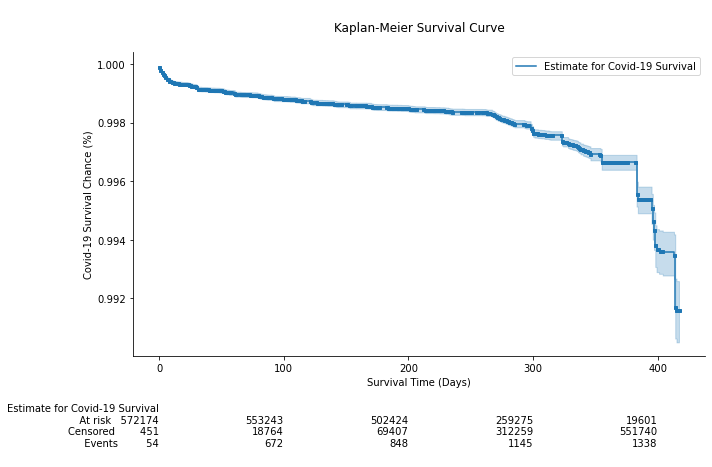

In [44]:
# fit kmf to the dataset
# weeks = (data['survival_duration'] / 7).round().values
# months = (data['survival_duration'] / 30).round().values

days = data['survival_duration'].values
dead = data['is_dead'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(days, event_observed=dead, label='Estimate for Covid-19 Survival')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,6))
kmf.plot(ax=ax,show_censors=True,censor_styles={'ms': 3,'marker':'s'},at_risk_counts=True)
ax.set_title('\nKaplan-Meier Survival Curve\n')
ax.set_xlabel('Survival Time (Days)')
ax.set_ylabel('Covid-19 Survival Chance (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

99% of the customers survived more than 400 days. 

In [45]:
# lifetable 
kmf.event_table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,505,54,451,572679,572679
1,189,62,127,0,572174
2,147,47,100,0,571985
3,103,24,79,0,571838
4,102,30,72,0,571735


In [46]:
# function for plotting Kaplan-Meier curve segmented
def plot_categorical_survival(feature, t='survival_duration', event='is_dead', df=data, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

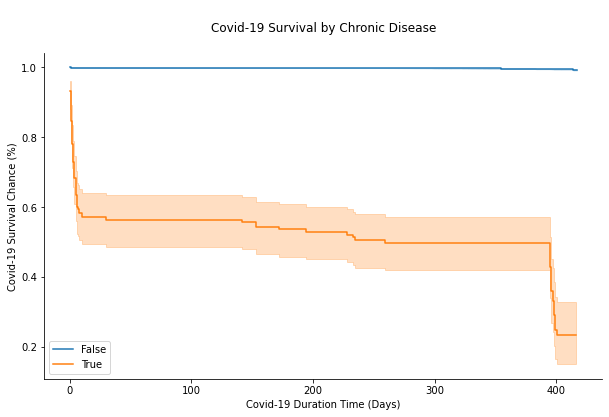

In [47]:
# plot by chronic disease
fig_edl, ax_edl = plt.subplots(figsize=(10,6))
plot_categorical_survival(feature='chronic_disease_binary', ax=ax_edl)
ax_edl.set_title('\nCovid-19 Survival by Chronic Disease\n')
ax_edl.set_xlabel('Covid-19 Duration Time (Days)')
ax_edl.set_ylabel('Covid-19 Survival Chance (%)')
ax_edl.spines['top'].set_visible(False)
ax_edl.spines['right'].set_visible(False);

Chronic Disease is a strong factor that influence the survival time. The patient's survival chance decreases substantially during 10 days after the confirmation. Normal people have absolute survival chance regardless of time after the confirmation.   

### (g) KM curve for gender, conduct log-rank test

In [48]:
# data['survival_months'] = (data['survival_duration'] / 30).round()

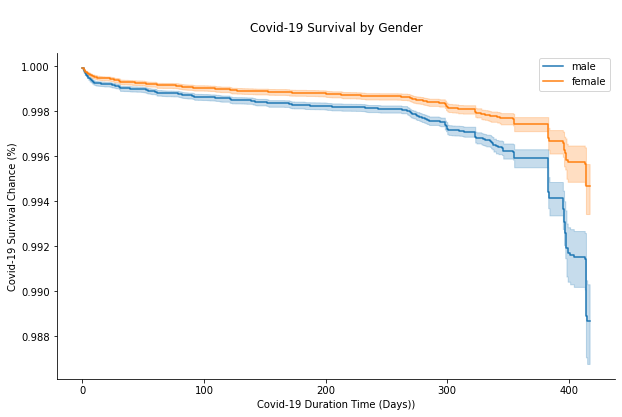

In [49]:
# plot by gender
fig_edl, ax_edl = plt.subplots(figsize=(10,6))
plot_categorical_survival(feature='sex', ax=ax_edl)
ax_edl.set_title('\nCovid-19 Survival by Gender\n')
ax_edl.set_xlabel('Covid-19 Duration Time (Days))')
ax_edl.set_ylabel('Covid-19 Survival Chance (%)')
ax_edl.spines['top'].set_visible(False)
ax_edl.spines['right'].set_visible(False);

Although there is a minor different between female and male, female obtains higher survival chance than male. However, both genders share the same pattern. More than 98% of them live more than 400 days.   

In [50]:
# check survival curves for different genders
female = (data['sex'] == 'female')
T = data['survival_duration']
E = data['is_dead']
kmf.fit(T[female], event_observed=E[female])

# calculate log rank test and print the result
covid_gender_results = logrank_test(T[female], T[~female], E[female], E[~female], alpha=.99)
covid_gender_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          65.83 <0.005     50.86

### Interpretation
The null hypothesis is that both genders have the same survival chance. 
The log-rank test provided a p-value of less than 0.005 (less than significant level 0.01). This indicates that the difference in survival between genders was statistically significant. In this case, I reject the null hypothesis and concludes that there is a different in survival chance between gender groups.

### (h) KM curve for age groups, conduct log-rank test

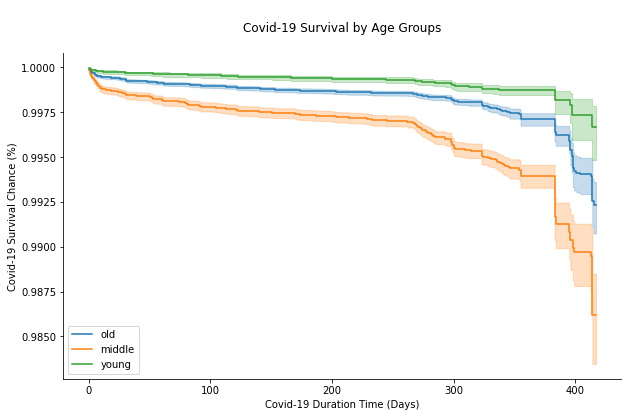

In [51]:
# plot by age groups
fig_edl, ax_edl = plt.subplots(figsize=(10,6))
plot_categorical_survival(feature='age_cat', ax=ax_edl)
ax_edl.set_title('\nCovid-19 Survival by Age Groups\n')
ax_edl.set_xlabel('Covid-19 Duration Time (Days)')
ax_edl.set_ylabel('Covid-19 Survival Chance (%)')
ax_edl.spines['top'].set_visible(False)
ax_edl.spines['right'].set_visible(False);

The older the patient, the lower survival chance. Old group has the lowest survival chance than others.

**Single**

In [52]:
# old
age_gr = (data['age_cat'] == 'old')
T = data['survival_duration']
E = data['is_dead']
kmf.fit(T[age_gr], event_observed=E[age_gr])

# calculate log rank test and print the result
covid_age_results = logrank_test(T[age_gr], T[~age_gr], E[age_gr], E[~age_gr], alpha=.99)
covid_age_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          40.01 <0.005     31.88

In [53]:
# middle
age_gr = (data['age_cat'] == 'middle')
T = data['survival_duration']
E = data['is_dead']
kmf.fit(T[age_gr], event_observed=E[age_gr])
covid_age_results = logrank_test(T[age_gr], T[~age_gr], E[age_gr], E[~age_gr], alpha=.99)
covid_age_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         311.90 <0.005    229.46

In [54]:
# young
age_gr = (data['age_cat'] == 'young')
T = data['survival_duration']
E = data['is_dead']
kmf.fit(T[age_gr], event_observed=E[age_gr])
covid_age_results = logrank_test(T[age_gr], T[~age_gr], E[age_gr], E[~age_gr], alpha=.99)
covid_age_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         118.20 <0.005     89.04

**Multiple**

In [56]:
# calculate log rank test
covid_age_results = multivariate_logrank_test(data['survival_duration'], data['age'], data['is_dead'], alpha=.99)
covid_age_results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 348
             alpha = 0.99
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
       31859.92 <0.005       inf

### Interpretation
The null hypothesis is that all age groups have the same survival chance. 
The log-rank test provided a p-value of less than 0.005 (less than significant level 0.01). This indicates that the difference in survival between age groups was statistically significant. In this case, I reject the null hypothesis and concludes that there is a different in survival chance among age categories.

### (i) Cox Model

In [57]:
data['female'] = data['sex'].map({'male': 0.0,'female': 1.0})
data['chronic_disease_binary'] = data['chronic_disease_binary'].map({'False': 0, 'True': 1})
data.head(2)

,age,sex,date_confirmation,chronic_disease_binary,date_death_or_discharge,outcome,age_cat,is_dead,survival_duration,female
0,78,male,2020-02-21,0,2020-02-22,death,old,1.0,1,0.0
1,61,female,2020-02-14,0,2020-02-17,discharge,middle,0.0,3,1.0


In [58]:
df = data.copy()
df.drop(['age','sex','date_confirmation','date_death_or_discharge','outcome'], axis=1, inplace=True)

In [60]:
df.head(2)

,chronic_disease_binary,age_cat,is_dead,survival_duration,female
0,0,old,1.0,1,0.0
1,0,middle,0.0,3,1.0


In [61]:
# one-hot encoding categorical data
df = pd.get_dummies(df, drop_first=True, columns=['age_cat'])

In [62]:
df['chronic_disease_binary'] = [float(i) for i in df['chronic_disease_binary']]
df['female'] = [float(i) for i in df['female']]

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572679 entries, 0 to 572678
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   chronic_disease_binary  572679 non-null  float64
 1   is_dead                 572679 non-null  float64
 2   survival_duration       572679 non-null  int64  
 3   female                  572679 non-null  float64
 4   age_cat_old             572679 non-null  uint8  
 5   age_cat_young           572679 non-null  uint8  
dtypes: float64(3), int64(1), uint8(2)
memory usage: 18.6 MB


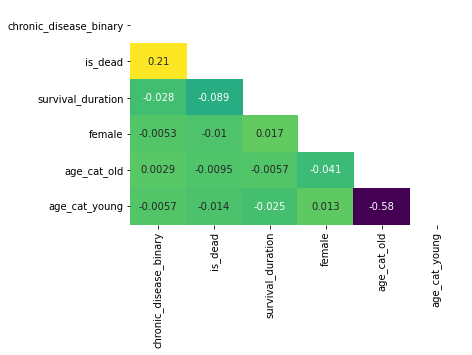

In [76]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cbar=False, cmap='viridis');

Age category has linear relation.

#### Multivariates

In [81]:
# covid_cph = lifelines.CoxPHFitter(penalizer=0.0001)
# covid_cph.fit(df, duration_col='survival_duration', event_col='is_dead', show_progress=False)
# covid_cph.print_summary()

In [82]:
# # plotting coefficients
# fig_coef, ax_coef = plt.subplots(figsize=(10,6))
# ax_coef.set_title('Survival Regression: Coefficients and Confidence Intervals\n')
# covid_cph.plot(ax=ax_coef);

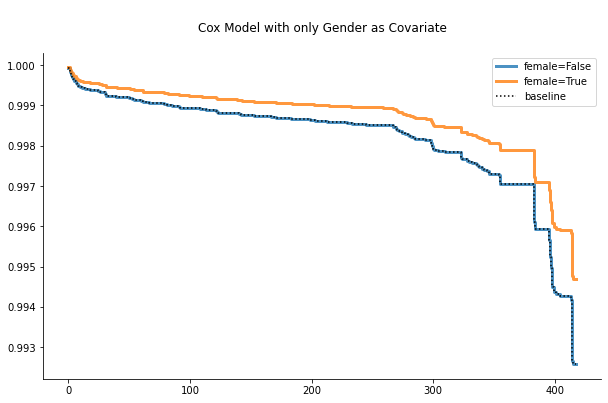

In [79]:
# check covariate gender group 
fig_co, ax_co = plt.subplots(figsize = (10,6))
covid_cph.plot_partial_effects_on_outcome('female', [False,True], lw=3, ax=ax_co, alpha=0.8)
ax_co.set_title('\nCox Model with only Gender as Covariate\n')
ax_co.spines['top'].set_visible(False)
ax_co.spines['right'].set_visible(False);

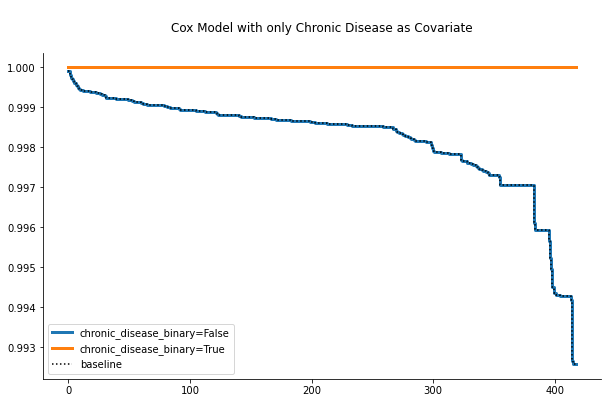

In [80]:
# check covariate chronic disease 
fig_co, ax_co = plt.subplots(figsize = (10,6))
covid_cph.plot_partial_effects_on_outcome('chronic_disease_binary', [False,True], lw=3, ax=ax_co)
ax_co.set_title('\nCox Model with only Chronic Disease as Covariate\n')
ax_co.spines['top'].set_visible(False)
ax_co.spines['right'].set_visible(False);

#### Gender as the only one covariate

In [83]:
df1 = data[['female','survival_duration','is_dead']].copy()
fe_cph = lifelines.CoxPHFitter() #penalizer=0.0001
fe_cph.fit(df1, duration_col='survival_duration', event_col='is_dead', show_progress=False)
fe_cph.print_summary()

<lifelines.CoxPHFitter: fitted with 572679 total observations, 571311 right-censored observations>
             duration col = 'survival_duration'
                event col = 'is_dead'
      baseline estimation = breslow
   number of observations = 572679
number of events observed = 1368
   partial log-likelihood = -17437.12
         time fit was run = 2021-03-26 07:57:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
female     -0.45       0.64       0.06            -0.56            -0.34                 0.57                 0.71

              z      p   -log2(p)
covariate                        
female    -8.05 <0.005      50.05
---
Concordance = 0.55
Partial AIC = 34876.24
log-likelihood ratio test = 66.83 on 1 df
-log2(p) of ll-ratio test = 51.59

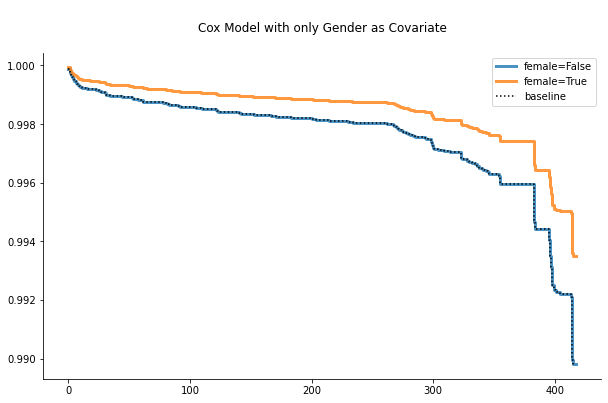

In [84]:
# check covariate gender group 
fig_co, ax_co = plt.subplots(figsize = (10,6))
fe_cph.plot_partial_effects_on_outcome('female', [False,True], lw=3, ax=ax_co, alpha=0.8)
ax_co.set_title('\nCox Model with only Gender as Covariate\n')
ax_co.spines['top'].set_visible(False)
ax_co.spines['right'].set_visible(False);

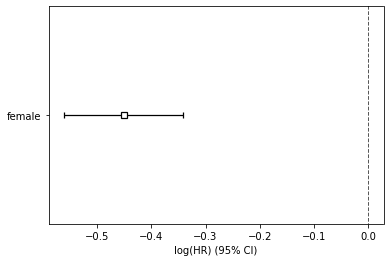

In [85]:
fe_cph.plot();

### (j) Gender as a stratify variable and Age Groups as a covariate.

In [ ]:
age_gen = data[['female','survival_duration','is_dead','age_cat']].copy()
age_gen = pd.get_dummies(age_gen, drop_first=False, columns=['age_cat'])
age_gen_cph = lifelines.CoxPHFitter(penalizer=0.0001) 
age_gen_cph.fit(age_gen, duration_col='survival_duration', event_col='is_dead', show_progress=False, strata='female')
age_gen_cph.print_summary()
age_gen_cph.check_assumptions(age_gen, p_value_threshold=0.05, show_plots=True)

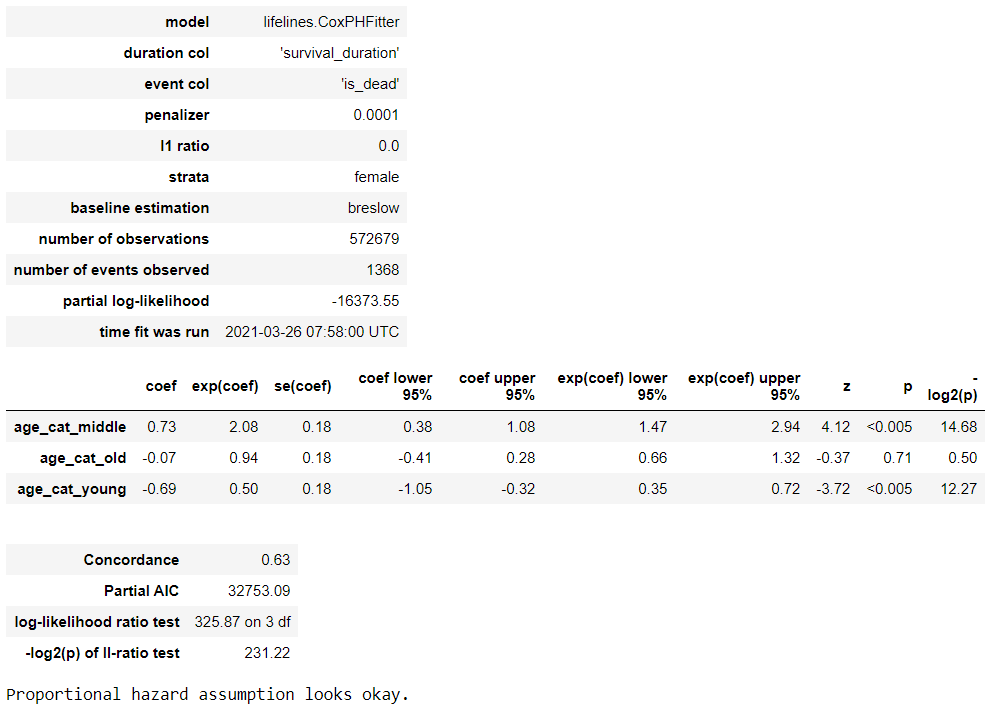

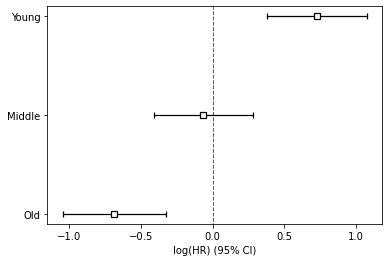

In [87]:
age_gen_cph.plot()
plt.yticks(np.arange(3), ('Old','Middle','Young'));

### (k) Weibull Model

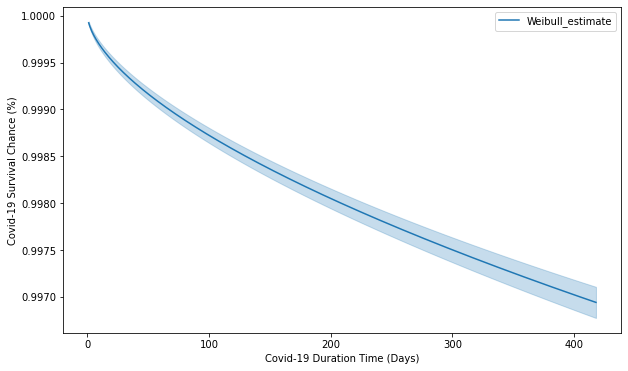

In [88]:
df2 = data.copy()
df2.loc[df2['survival_duration'] == 0 ]
from lifelines import WeibullFitter
wbf = WeibullFitter().fit(data['survival_duration']+1, event_observed=data['is_dead'])
ax = wbf.plot_survival_function(figsize=(10,6))
ax.set_ylabel('Covid-19 Survival Chance (%)')
ax.set_xlabel('Covid-19 Duration Time (Days)');

Weibull model shows that the death rate decreases over time. This parametric model has a smooth curve which is simultaneously proportional and accelerated. The relative event rates and survival time can be estimated.

## 5. Conclusion

- Kaplan-Meier curves show that there is a difference on survival rate between genders or among the age groups. 
- Gender as the only covariate is not trustful enough for the prediction of who in the pair (the case with high risk score or the case with lower risk score) will die sooner just based on gender. However, when adding age groups as covariate and gender as a stratify, the predictor performs much better and with high confidence.